### 5.6.2　基函数回归
你可以通过基函数对原始数据进行变换，从而将变量间的线性回归模型转换为非线性回归模型。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
# plt.scatter(x, y);

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
# plt.scatter(x, y)
# plt.plot(xfit, yfit);

#### 1. 多项式基函数
多项式投影非常有用，因此Scikit-Learn 内置了PolynomialFeatures 转换器实现这个功能：

In [2]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

转换器通过指数函数，将一维数组转换成了三维数组。这个新的高维数组之后可以放在多项式回归模型中。

就像在5.4 节介绍的那样，最简洁的方式是用管道实现这些过程。让我们创建一个7 次多项式回归模型：

In [3]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

数据经过转换之后，我们就可以用线性模型来拟合x 和y 之间更复杂的关系了。
<br>例如，下面是一条带噪的正弦波（如图5-44 所示）：

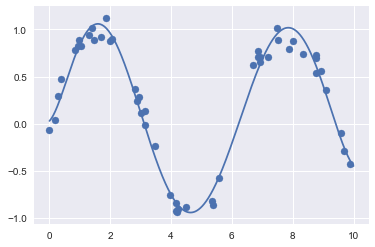

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

通过运用7 次多项式基函数，这个线性模型可以对非线性数据拟合出极好的效果！

#### 2. 高斯基函数
当然还有其他类型的基函数。例如，有一种常用的拟合模型方法使用的并不是一组多项式基函数，而是一组高斯基函数。最终结果如图5-45 所示。

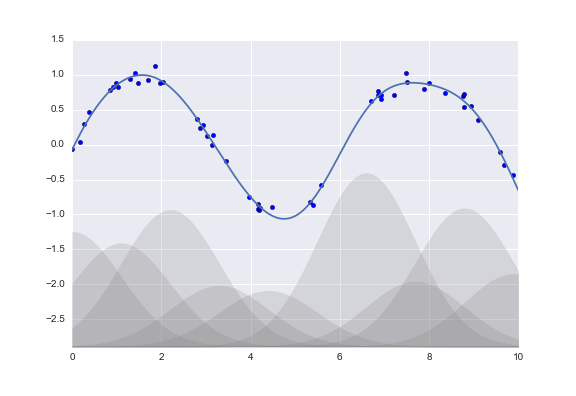
图5-45 中的阴影部分代表不同规模基函数，把它们放在一起时就会产生平滑的曲线。

Scikit-Learn 并没有内置这些高斯基函数，但我们可以自己写一个转换器来创建高斯基函数，效果如图5-46 所示（Scikit-Learn 的转换器都是用Python 类实现的，阅读Scikit-Learn的源代码可能更好地理解它们的创建方式）：

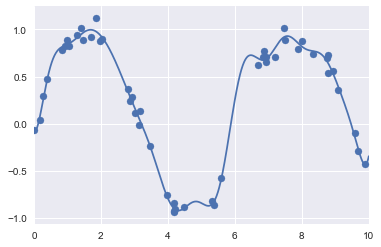

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """一维输入均匀分布的高斯特征"""
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # 在数据区间中创建N个高斯分布中心
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

我们之所以将这个示例放在这里，是为了演示多项式基函数并不是什么魔法：如果你对数据的产生过程有某种直觉，那么就可以自己先定义一些基函数，然后像这样使用它们。